In [3]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

# Load the data

In [4]:
import datetime
from helpers import *

height, weight, gender = load_data(sub_sample=False, add_outlier=False)
x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

In [5]:
y.shape, tx.shape

((10000,), (10000, 2))

### NB: throughout this laboratory the data has the following format: 
  * there are **N = 10000** data entries
  * **y** represents the column vector containing weight information -- that which we wish to predict/the output (see also the first page of $\texttt{exercise02.pdf}$). Its **shape** is **(N,)**.
  * **tx** represents the matrix $\tilde{X}$ formed by laterally concatenating a column vector of 1s to the column vector of height information -- the input data (see also the first page of $\texttt{exercise02.pdf}$). Its **shape** is **(N,2)**.

# 1. Computing the Cost Function
See file costs.py

In [6]:
def mse(e):
    return 1/(2*len(e)) * np.dot(e, e)

def mae(e):
    return 1/(2*len(e)) * np.sum(np.abs(e))

def compute_loss(y, tx, w):
    """Calculate the loss using either MSE or MAE.

    Args:
        y: shape=(N, )
        tx: shape=(N,2)
        w: shape=(2,). The vector of model parameters.

    Returns:
        the value of the loss (a scalar), corresponding to the input parameters w.
    """
    e = tx @ w - y
    return mse(e)

# 2. Grid Search

Fill in the function `grid_search()` below:

In [7]:
from costs import compute_loss


def grid_search(y, tx, grid_w0, grid_w1):
    """Algorithm for grid search.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        grid_w0: numpy array of shape=(num_grid_pts_w0, ). A 1D array containing num_grid_pts_w0 values of parameter w0 to be tested in the grid search.
        grid_w1: numpy array of shape=(num_grid_pts_w1, ). A 1D array containing num_grid_pts_w1 values of parameter w1 to be tested in the grid search.

    Returns:
        losses: numpy array of shape=(num_grid_pts_w0, num_grid_pts_w1). A 2D array containing the loss value for each combination of w0 and w1
    """

    losses = np.zeros((len(grid_w0), len(grid_w1)))
    for row, w0 in enumerate(grid_w0):
        for col, w1 in enumerate(grid_w1):
            losses[row, col] = compute_loss(y, tx, np.array([w0, w1]))
    return losses

Let us play with the grid search demo now!

Grid Search: loss*=18.79354101952324, w0*=71.42857142857142, w1*=15.306122448979579, execution time=0.279 seconds


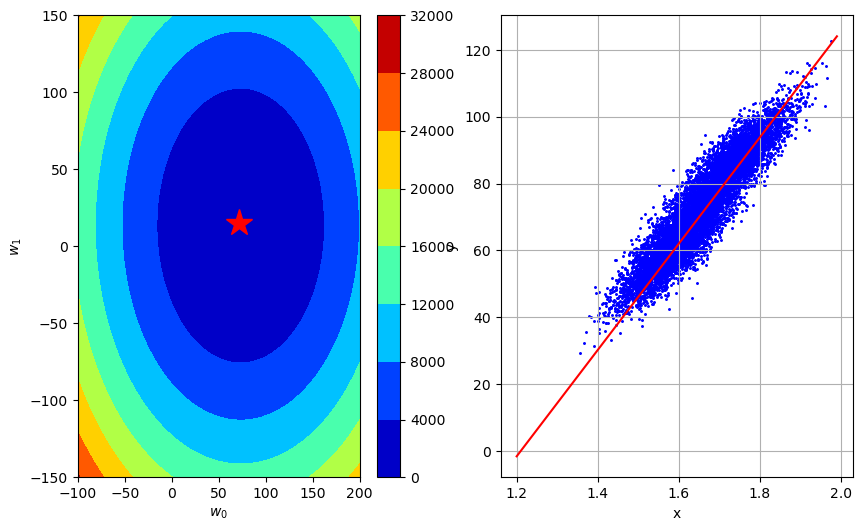

In [9]:
from grid_search import generate_w, get_best_parameters, grid_search
from plots import grid_visualization

# Generate the grid of parameters to be swept
grid_w0, grid_w1 = generate_w(num_intervals=50)

# Start the grid search
start_time = datetime.datetime.now()
grid_losses = grid_search(y, tx, grid_w0, grid_w1)

# Select the best combinaison
loss_star, w0_star, w1_star = get_best_parameters(grid_w0, grid_w1, grid_losses)
end_time = datetime.datetime.now()
execution_time = (end_time - start_time).total_seconds()

# Print the results
print(
    "Grid Search: loss*={l}, w0*={w0}, w1*={w1}, execution time={t:.3f} seconds".format(
        l=loss_star, w0=w0_star, w1=w1_star, t=execution_time
    )
)

# Plot the results
fig = grid_visualization(grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight)
fig.set_size_inches(10.0, 6.0)
fig.savefig("grid_plot")  # Optional saving

# 3. Gradient Descent

Again, please fill in the functions `compute_gradient` below:

In [12]:
def compute_gradient(y, tx, w):
    """Computes the gradient at w.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2, ). The vector of model parameters.

    Returns:
        An numpy array of shape (2, ) (same shape as w), containing the gradient of the loss at w.
    """
    e = y - tx @ w
    return - 1/len(e) * tx.T @ e

print(f"grad for 100 + 20x: {compute_gradient(y, tx, [100, 20])}") ## 100 and 20 should be smaller
print(f"grad for 50 + 10x: {compute_gradient(y, tx, [50, 10])}") ## 50 and 10 should be bigger (10 slightly)

grad for 100 + 20x: [26.706078    6.52028757]
grad for 50 + 10x: [-23.293922    -3.47971243]


Please fill in the functions `gradient_descent` below:

In [13]:
def gradient_descent(y, tx, initial_w, max_iters, gamma):
    """The Gradient Descent (GD) algorithm.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        max_iters: a scalar denoting the total number of iterations of GD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of GD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of GD
    """
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        grad = compute_gradient(y, tx, w)
        loss = compute_loss(y, tx, w)

        w = w - gamma * grad

        # store w and loss
        ws.append(w)
        losses.append(loss)
        print(
            "GD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )

    return losses, ws

Test your gradient descent function through gradient descent demo shown below:

In [30]:
# from gradient_descent import *
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.1

# Initialization
w_initial = np.array([0, 0])

# Start gradient descent.
start_time = datetime.datetime.now()
gd_losses, gd_ws = gradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("GD: execution time={t:.3f} seconds".format(t=exection_time))

GD iter. 0/49: loss=2792.236712759168, w0=7.329392200210518, w1=1.347971243498896
GD iter. 1/49: loss=2264.6350560300034, w0=13.925845180399984, w1=2.5611453626479044
GD iter. 2/49: loss=1837.2777140793805, w0=19.862652862570506, w1=3.653002069882011
GD iter. 3/49: loss=1491.1182670993753, w0=25.205779776523975, w1=4.63567310639271
GD iter. 4/49: loss=1210.7291150455717, w0=30.014593999082095, w1=5.520077039252341
GD iter. 5/49: loss=983.6139018819908, w0=34.3425267993844, w1=6.316040578826008
GD iter. 6/49: loss=799.6505792194903, w0=38.23766631965648, w1=7.032407764442307
GD iter. 7/49: loss=650.6402878628647, w0=41.74329188790136, w1=7.677138231496977
GD iter. 8/49: loss=529.9419518639978, w0=44.89835489932174, w1=8.257395651846181
GD iter. 9/49: loss=432.17629970491606, w0=47.73791160960008, w1=8.779627330160464
GD iter. 10/49: loss=352.9861214560596, w0=50.293512648850594, w1=9.24963584064332
GD iter. 11/49: loss=288.84207707448587, w0=52.59355358417605, w1=9.67264350007789
GD ite

In [31]:
# Time Visualization
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gd_losses,
        gd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(gd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

# 4. Stochastic gradient descent

In [35]:
from helpers import batch_iter

def compute_stoch_gradient(y, tx, w):
    """Compute a stochastic gradient at w from just few examples n and their corresponding y_n labels.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2, ). The vector of model parameters.

    Returns:
        A numpy array of shape (2, ) (same shape as w), containing the stochastic gradient of the loss at w.
    """

    e = y - tx @ w
    return - 1/len(e) * tx.T @ e


def stochastic_gradient_descent(y, tx, initial_w, batch_size, max_iters, gamma):
    """The Stochastic Gradient Descent algorithm (SGD).

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        batch_size: a scalar denoting the number of data points in a mini-batch used for computing the stochastic gradient
        max_iters: a scalar denoting the total number of iterations of SGD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SGD
    """

    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w

    for n_iter in range(max_iters):
        total_batches = len(y) // batch_size
        avg_loss = 0
        for (batch_y, batch_tx) in batch_iter(y, tx, batch_size=batch_size, num_batches=total_batches):
            grad = compute_gradient(batch_y, batch_tx, w)
            avg_loss += compute_loss(batch_y, batch_tx, w)
            w = w - gamma * grad
        avg_loss /= total_batches
        losses.append(avg_loss)
        ws.append(w)
        print(
            "SGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=avg_loss, w0=w[0], w1=w[1]
            )
        )
    return losses, ws

In [36]:
# from stochastic_gradient_descent import *

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.1
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SGD.
start_time = datetime.datetime.now()
sgd_losses, sgd_ws = stochastic_gradient_descent(
    y, tx, w_initial, batch_size, max_iters, gamma
)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

SGD iter. 0/49: loss=18.647730025747677, w0=75.29561736161634, w1=14.860441684443261
SGD iter. 1/49: loss=16.999274376344207, w0=73.42789217139433, w1=14.378866490653683
SGD iter. 2/49: loss=17.05027494337455, w0=76.70600113071669, w1=13.298845313048936
SGD iter. 3/49: loss=16.93290425609236, w0=71.41428417919289, w1=13.804937159330382
SGD iter. 4/49: loss=17.011293510221996, w0=73.26506105540919, w1=12.472771194043814
SGD iter. 5/49: loss=16.970833299202834, w0=73.16578022810862, w1=11.83440656680517
SGD iter. 6/49: loss=17.015588273216217, w0=74.21730433532116, w1=15.428234404498626
SGD iter. 7/49: loss=17.03287685917865, w0=71.88114722111875, w1=14.382385994859861
SGD iter. 8/49: loss=16.95517132354711, w0=73.90616492709225, w1=14.078184869304883
SGD iter. 9/49: loss=17.07463122901692, w0=72.55827930161843, w1=13.243124730475701
SGD iter. 10/49: loss=16.951935204790598, w0=73.5669575393563, w1=11.56736889543364
SGD iter. 11/49: loss=16.9876988067353, w0=75.90751936513537, w1=13.8994

In [37]:
# Time Visualization
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        sgd_losses,
        sgd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(sgd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

# 5. Effect of Outliers and MAE Cost Function

In [38]:
import datetime
from helpers import *

height, weight, gender = load_data(sub_sample=True, add_outlier=True)
x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

In [39]:
y.shape, tx.shape

((202,), (202, 2))

In [41]:
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.7

# Initialization
w_initial = np.array([0, 0])

# Start gradient descent.
start_time = datetime.datetime.now()

gd_losses, gd_ws = gradient_descent(y, tx, w_initial, max_iters, gamma) 

end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("GD: execution time={t:.3f} seconds".format(t=exection_time))

GD iter. 0/49: loss=2869.8351145358524, w0=51.847464098448434, w1=7.724426406192428
GD iter. 1/49: loss=318.2821247015961, w0=67.40170332798299, w1=10.041754328050118
GD iter. 2/49: loss=88.6423556165127, w0=72.06797509684336, w1=10.736952704607411
GD iter. 3/49: loss=67.9747763988552, w0=73.46785662750146, w1=10.945512217574596
GD iter. 4/49: loss=66.11469426926604, w0=73.88782108669889, w1=11.00808007146475
GD iter. 5/49: loss=65.94728687760302, w0=74.01381042445813, w1=11.026850427631796
GD iter. 6/49: loss=65.93222021235334, w0=74.0516072257859, w1=11.03248153448191
GD iter. 7/49: loss=65.93086421248088, w0=74.06294626618423, w1=11.034170866536943
GD iter. 8/49: loss=65.93074217249234, w0=74.06634797830372, w1=11.034677666153454
GD iter. 9/49: loss=65.93073118889338, w0=74.06736849193958, w1=11.034829706038407
GD iter. 10/49: loss=65.93073020036948, w0=74.06767464603033, w1=11.034875318003893
GD iter. 11/49: loss=65.93073011140231, w0=74.06776649225755, w1=11.03488900159354
GD iter

In [42]:
# Time Visualization
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gd_losses,
        gd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(gd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

# 6. Subgradient descent

In [49]:
def compute_subgradient_mae(y, tx, w):
    """Compute a subgradient of the MAE at w.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2, ). The vector of model parameters.

    Returns:
        A numpy array of shape (2, ) (same shape as w), containing the subgradient of the MAE at w.
    """
    N = len(y)
    return - 1/N * np.sign(y - tx @ w) @ tx

In [50]:
from costs import mae

def subgradient_descent(y, tx, initial_w, max_iters, gamma):
    """The SubGradient Descent (SubGD) algorithm.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        max_iters: a scalar denoting the total number of iterations of GD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SubGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SubGD
    """
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        
        loss = compute_loss(y, tx, w, loss=mae)
        subgrad = compute_subgradient_mae(y, tx, w)
        w = w - gamma * subgrad

        ws.append(w)
        losses.append(loss)
        print(
            "SubGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )

    return losses, ws

In [51]:
# Define the parameters of the algorithm.
max_iters = 500
gamma = 0.7
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SubSGD.
start_time = datetime.datetime.now()
subgd_losses, subgd_ws = subgradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SubGD: execution time={t:.3f} seconds".format(t=exection_time))

SubGD iter. 0/499: loss=37.03390292746319, w0=0.7000000000000004, w1=7.338997388192976e-16
SubGD iter. 1/499: loss=36.68390292746319, w0=1.4000000000000008, w1=1.4677994776385952e-15
SubGD iter. 2/499: loss=36.333902927463186, w0=2.1000000000000014, w1=2.2016992164578927e-15
SubGD iter. 3/499: loss=35.983902927463184, w0=2.8000000000000016, w1=2.9355989552771903e-15
SubGD iter. 4/499: loss=35.63390292746319, w0=3.5000000000000018, w1=3.669498694096488e-15
SubGD iter. 5/499: loss=35.283902927463195, w0=4.200000000000002, w1=4.403398432915785e-15
SubGD iter. 6/499: loss=34.93390292746319, w0=4.900000000000002, w1=5.137298171735083e-15
SubGD iter. 7/499: loss=34.583902927463186, w0=5.600000000000002, w1=5.87119791055438e-15
SubGD iter. 8/499: loss=34.233902927463184, w0=6.3000000000000025, w1=6.605097649373677e-15
SubGD iter. 9/499: loss=33.88390292746319, w0=7.000000000000003, w1=7.338997388192974e-15
SubGD iter. 10/499: loss=33.53390292746319, w0=7.700000000000003, w1=8.072897127012273e

In [52]:
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        subgd_losses,
        subgd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(subgd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=501, min=1), Output()), _dom_classes=('widg…

<function __main__.plot_figure(n_iter)>

# Stochastic Subgradient Descent

**NB** for the computation of the subgradient you can reuse the `compute_subgradient` method that you implemented above, just making sure that you pass in a minibatch as opposed to the full data.

In [53]:
def stochastic_subgradient_descent(y, tx, initial_w, batch_size, max_iters, gamma):
    """The Stochastic SubGradient Descent algorithm (SubSGD).

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        batch_size: a scalar denoting the number of data points in a mini-batch used for computing the stochastic subgradient
        max_iters: a scalar denoting the total number of iterations of SubSGD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SubSGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SubSGD
    """

    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w

    for n_iter in range(max_iters):
        total_batches = len(y) // batch_size
        avg_loss = 0
        for (batch_y, batch_tx) in batch_iter(y, tx, batch_size=batch_size, num_batches=total_batches):
            grad = compute_subgradient_mae(batch_y, batch_tx, w)
            avg_loss += compute_loss(batch_y, batch_tx, w, loss=mae)
            w = w - gamma * grad
        avg_loss /= total_batches
        losses.append(avg_loss)
        ws.append(w)

        print(
            "SubSGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=avg_loss, w0=w[0], w1=w[1]
            )
        )
    return losses, ws

In [54]:
# Define the parameters of the algorithm.
max_iters = 500
gamma = 0.7
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SubSGD.
start_time = datetime.datetime.now()
subsgd_losses, subsgd_ws = stochastic_subgradient_descent(
    y, tx, w_initial, batch_size, max_iters, gamma
)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SubSGD: execution time={t:.3f} seconds".format(t=exection_time))

SubSGD iter. 0/499: loss=11.774982694861292, w0=71.40000000000013, w1=14.642159769638003
SubSGD iter. 1/499: loss=2.8929556370388707, w0=72.80000000000014, w1=16.261949692598613
SubSGD iter. 2/499: loss=2.8750138384794233, w0=72.80000000000014, w1=16.308157089447793
SubSGD iter. 3/499: loss=2.8467595172837843, w0=72.80000000000014, w1=14.342928248080968
SubSGD iter. 4/499: loss=2.7889771272093284, w0=75.60000000000015, w1=11.152234991876064
SubSGD iter. 5/499: loss=2.942604972214299, w0=72.80000000000014, w1=17.325745647554413
SubSGD iter. 6/499: loss=2.8027114705473206, w0=71.40000000000013, w1=17.046078983868874
SubSGD iter. 7/499: loss=2.856195099000049, w0=75.60000000000015, w1=17.618696452114488
SubSGD iter. 8/499: loss=2.829495988270998, w0=70.00000000000013, w1=14.172180752920225
SubSGD iter. 9/499: loss=2.908552053362483, w0=71.40000000000013, w1=13.541539226831873
SubSGD iter. 10/499: loss=2.8165569738456493, w0=70.00000000000013, w1=15.555819955076364
SubSGD iter. 11/499: los

In [55]:
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        subsgd_losses,
        subsgd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(subsgd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=501, min=1), Output()), _dom_classes=('widg…

<function __main__.plot_figure(n_iter)>